# AT&T Hackathon Brno

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

# 1 Preprocessing, Feature Engineering

In [2]:
data_supervised = pd.read_csv("../datasets/ML_DATASET_Hackathon_Supervised.csv").dropna().drop_duplicates().drop('Unnamed: 0', axis=1)
data_supervised.head()

,Ticket,Problem_Abstract,Ticket_Type,Team,Ticket_Opened_Date,Ticket_Closed
0,272431733,The CUC Database is not running on DURPRIPT7B,User,Prognosis,12/18/2019 14:20,7/27/2022 20:49
1,271472293,OPEN CR:Alerts not being generated - trap ba...,User,SMARTS/GFP_CPE,11/20/2019 18:33,12/23/2021 10:44
2,256576476,Enhancement to TWB Portal GPS SYNC Reports - A...,User,INCM (Voyence),2/19/2019 19:34,8/12/2022 16:35
3,271503232,Duplicated/ triplicated exceptions on Exceptio...,User,ATTLAS,11/21/2019 13:11,11/7/2021 11:22
4,277339571,"vnsd90, HPE account, JuniperRPM VitalArt issue",User,VitalNet Problems or Errors,5/8/2020 22:38,12/23/2021 10:44


In [3]:
def add_dt_vars(df):
    """
    Convert start + end variables to datetime
    """
    df_added = df.copy()
    df_added[['Ticket_Opened_Date', 'Ticket_Closed']] = df_added[['Ticket_Opened_Date', 'Ticket_Closed']].apply(pd.to_datetime)

    return df_added

In [4]:
data_supervised = add_dt_vars(data_supervised)

In [5]:
def get_datetime_features(df):
    """
    Add datetime features to the dataset
    :param df:
    :return: pd.DataFrame
    """

    data_transformed = df.copy()

    data_transformed[['Ticket_Opened_Date', 'Ticket_Closed']] = data_transformed[['Ticket_Opened_Date', 'Ticket_Closed']].apply(pd.to_datetime)
    data_transformed['open_day_of_week'] = data_transformed['Ticket_Opened_Date'].dt.dayofweek.astype("int")
    data_transformed['close_day_of_week'] = data_transformed['Ticket_Closed'].dt.dayofweek.astype("int")
    data_transformed['open_calender_week'] = data_transformed['Ticket_Opened_Date'].dt.week
    data_transformed['close_calender_week'] = data_transformed['Ticket_Closed'].dt.week
    data_transformed['open_month'] = data_transformed['Ticket_Opened_Date'].dt.month.astype("int")
    data_transformed['open_year'] = data_transformed['Ticket_Opened_Date'].dt.year.astype("int")
    data_transformed['is_friday'] = np.where(data_transformed['open_day_of_week'] == 4, 1, 0)
    data_transformed['duration'] = data_transformed['Ticket_Closed'] - data_transformed['Ticket_Opened_Date']
    data_transformed['hr_duration'] = data_transformed['duration']/np.timedelta64(1, 'h')
    data_transformed['opened_hour'] = data_transformed['Ticket_Opened_Date'].dt.hour
    data_transformed['open_hour_sin'] = np.sin(2 * np.pi * data_transformed['opened_hour']/24.0)
    data_transformed['open_hour_cos'] = np.cos(2 * np.pi * data_transformed['opened_hour']/24.0)

    return data_transformed

In [6]:
data_supervised = get_datetime_features(data_supervised)

C:\Users\A200083283\AppData\Local\Temp\ipykernel_19828\3500048071.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_transformed['open_calender_week'] = data_transformed['Ticket_Opened_Date'].dt.week
C:\Users\A200083283\AppData\Local\Temp\ipykernel_19828\3500048071.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_transformed['close_calender_week'] = data_transformed['Ticket_Closed'].dt.week


In [7]:
data_supervised = data_supervised.drop_duplicates(subset=['Problem_Abstract', 'open_calender_week', 'Team'])

In [8]:
import datetime
import holidays

def generate_calendar_based_features(country_name, datetime_index):
    """
    Generates calendar-based exogenous features based on a datetime index (month of the year, if the day is a holiday)
    :param country_name: str
    :param datetime_index: pd.DatetimeIndex
    :return: pd.DataFrame
    """
    X_dataframe = pd.DataFrame(index=datetime_index)
    years_list = datetime_index.year.unique()
    country_specific_holidays = get_country_holidays(country_name, years_list)
    X_dataframe['month'] = X_dataframe.index.month
    X_dataframe['dayoftheweek'] = X_dataframe.index.dayofweek
    X_dataframe['year'] = X_dataframe.index.year
    X_dataframe['is_holiday'] = [1 if x.date() in country_specific_holidays else 0 for x in X_dataframe.index]

    return X_dataframe

def get_country_holidays(country_name, years_list):
    """
    Based on a country name, it generates the holidays for that country.
    :param country_name:  str
    :param years_list: list of int
    :return: list of str
    """
    holidays_list = holidays.country_holidays(country=country_name, years=years_list)
    dates_list = list(holidays_list.keys())

    additional_holidays_list = []
    for each_year in years_list:
        additional_holidays_list.append(datetime.date(each_year, 12, 31))
        additional_holidays_list.append(datetime.date(each_year, 12, 24))

    return dates_list+additional_holidays_list

holiday_df = generate_calendar_based_features("Czechia", pd.DatetimeIndex(data_supervised['Ticket_Opened_Date'])).reset_index()[['Ticket_Opened_Date', 'is_holiday']]


In [9]:
data_supervised = data_supervised.merge(holiday_df)

## 2 EDA

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [11]:
data_supervised.head()

,Ticket,Problem_Abstract,Ticket_Type,Team,Ticket_Opened_Date,Ticket_Closed,open_day_of_week,close_day_of_week,open_calender_week,close_calender_week,open_month,open_year,is_friday,duration,hr_duration,opened_hour,open_hour_sin,open_hour_cos,is_holiday
0,272431733,The CUC Database is not running on DURPRIPT7B,User,Prognosis,2019-12-18 14:20:00,2022-07-27 20:49:00,2,2,51,30,12,2019,0,952 days 06:29:00,22854.483333,14,-0.500000,-8.660254e-01,0
1,271472293,OPEN CR:Alerts not being generated - trap ba...,User,SMARTS/GFP_CPE,2019-11-20 18:33:00,2021-12-23 10:44:00,2,3,47,51,11,2019,0,763 days 16:11:00,18328.183333,18,-1.000000,-1.836970e-16,0
2,256576476,Enhancement to TWB Portal GPS SYNC Reports - A...,User,INCM (Voyence),2019-02-19 19:34:00,2022-08-12 16:35:00,1,4,8,32,2,2019,0,1269 days 21:01:00,30477.016667,19,-0.965926,2.588190e-01,0
3,271503232,Duplicated/ triplicated exceptions on Exceptio...,User,ATTLAS,2019-11-21 13:11:00,2021-11-07 11:22:00,3,6,47,44,11,2019,0,716 days 22:11:00,17206.183333,13,-0.258819,-9.659258e-01,0
4,277339571,"vnsd90, HPE account, JuniperRPM VitalArt issue",User,VitalNet Problems or Errors,2020-05-08 22:38:00,2021-12-23 10:44:00,4,3,19,51,5,2020,1,593 days 12:06:00,14244.100000,22,-0.500000,8.660254e-01,1


<AxesSubplot: xlabel='hr_duration', ylabel='Count'>

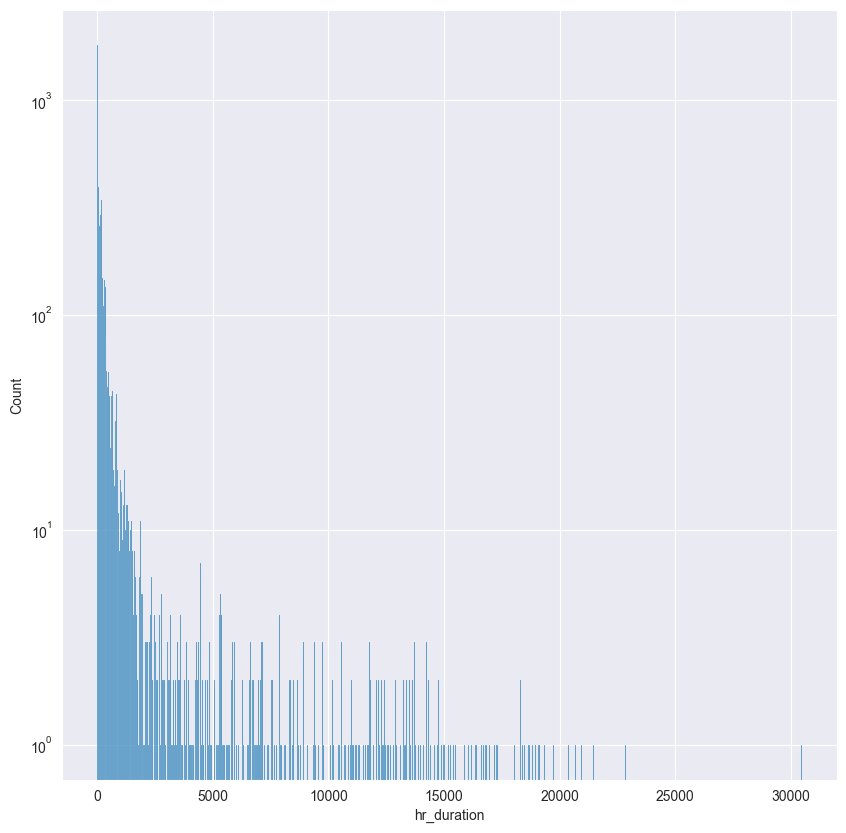

In [12]:
sns.histplot(data=data_supervised, x="hr_duration", log=True)

In [13]:
# pd.concat([data_supervised['Team'], pd.get_dummies(data_supervised, columns=['Team'])], axis=1)

## 3 Modelling

In [14]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data_supervised)

In [15]:
data_train.head()

,Ticket,Problem_Abstract,Ticket_Type,Team,Ticket_Opened_Date,Ticket_Closed,open_day_of_week,close_day_of_week,open_calender_week,close_calender_week,open_month,open_year,is_friday,duration,hr_duration,opened_hour,open_hour_sin,open_hour_cos,is_holiday
1427,307287205,Down Devices Not Working Correctly,User,iGEMS-NG (NextGEMS),2022-02-02 15:38:00,2022-02-16 22:14:00,2,2,5,7,2,2022,0,14 days 06:36:00,342.600000,15,-0.707107,-7.071068e-01,0
1914,308344994,"Please remove keho_wmg from the ""MSS_WarnerMe...",User,GTAC,2022-03-11 16:50:00,2022-03-11 17:48:00,4,4,10,10,3,2022,1,0 days 00:58:00,0.966667,16,-0.866025,-5.000000e-01,0
185,302502259,No ticket cut for member 2 of stack switch down,User,SMARTS/GFP_CPE,2021-08-13 10:26:00,2021-12-23 11:27:00,4,3,32,51,8,2021,1,132 days 01:01:00,3169.016667,10,0.500000,-8.660254e-01,0
4768,310756529,Create GTAC Tools ID for Customer MSS_GSG_MNAIX,User,GTAC - Other,2022-06-10 22:22:00,2022-06-23 14:02:00,4,3,23,25,6,2022,1,12 days 15:40:00,303.666667,22,-0.500000,8.660254e-01,0
2951,310650094,Manual Remove from Power BI,User,Global Delivery Data & Analytics,2022-06-07 18:39:00,2022-06-08 17:16:00,1,2,23,23,6,2022,0,0 days 22:37:00,22.616667,18,-1.000000,-1.836970e-16,0


In [16]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 5)
    upper_limit = s.mean() + (s.std() * 3)

    return ~s.between(lower_limit, upper_limit)

data_train = data_train[~data_train.groupby('Team')['hr_duration'].apply(is_outlier)]

C:\Users\A200083283\AppData\Local\Temp\ipykernel_19828\1936067010.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_train = data_train[~data_train.groupby('Team')['hr_duration'].apply(is_outlier)]


In [17]:
def get_relevant_features(df, r="open|is|Team"):
    """
    Get relevant features of the data set
    """
    feature_index = df.filter(regex=r).columns.drop(['opened_hour'])

    return feature_index

In [18]:
features = get_relevant_features(data_train)
features

Index(['Team', 'open_day_of_week', 'open_calender_week', 'open_month',
       'open_year', 'is_friday', 'open_hour_sin', 'open_hour_cos',
       'is_holiday'],
      dtype='object')

In [19]:
from catboost import CatBoostRegressor
from catboost import Pool

def modelling_pipeline(df, features):

    X_train, y_train = df.drop(['hr_duration'], axis=1)[features], (df['hr_duration'])
    model = CatBoostRegressor(iterations=1000, learning_rate=0.3, depth=4, one_hot_max_size=1000)
    pool_train = Pool(X_train, y_train, cat_features = ['Team'])
    X_test = data_test.drop(['hr_duration'], axis=1)[features]
    pool_test = Pool(X_test, cat_features = ['Team'])
    fit = model.fit(pool_train)

    y_pred = model.predict(pool_test)
    y_pred = (np.abs(y_pred)+y_pred)/2

    return X_train, X_test, y_pred, model

In [20]:
X_train, X_test, y_pred, model = modelling_pipeline(data_train, features)

0:	learn: 1720.9000585	total: 142ms	remaining: 2m 22s
1:	learn: 1434.4494833	total: 144ms	remaining: 1m 11s
2:	learn: 1288.4504543	total: 145ms	remaining: 48.1s
3:	learn: 1165.4723868	total: 146ms	remaining: 36.3s
4:	learn: 1041.4121006	total: 147ms	remaining: 29.2s
5:	learn: 946.5195450	total: 148ms	remaining: 24.5s
6:	learn: 895.8248424	total: 149ms	remaining: 21.2s
7:	learn: 883.3241008	total: 150ms	remaining: 18.6s
8:	learn: 861.9592253	total: 151ms	remaining: 16.6s
9:	learn: 846.2769169	total: 152ms	remaining: 15s
10:	learn: 832.4962325	total: 153ms	remaining: 13.8s
11:	learn: 828.6337671	total: 155ms	remaining: 12.8s
12:	learn: 817.0326258	total: 157ms	remaining: 11.9s
13:	learn: 798.4806590	total: 158ms	remaining: 11.1s
14:	learn: 792.7701947	total: 159ms	remaining: 10.4s
15:	learn: 785.2120370	total: 160ms	remaining: 9.82s
16:	learn: 782.8329622	total: 161ms	remaining: 9.3s
17:	learn: 779.8990990	total: 162ms	remaining: 8.83s
18:	learn: 778.0965789	total: 163ms	remaining: 8.41s

In [21]:
from sklearn.metrics import mean_absolute_error as MAE

In [22]:
y_test= data_test['hr_duration']
MAE(y_pred, y_test)

460.3166806405746

<AxesSubplot: xlabel='hr_duration'>

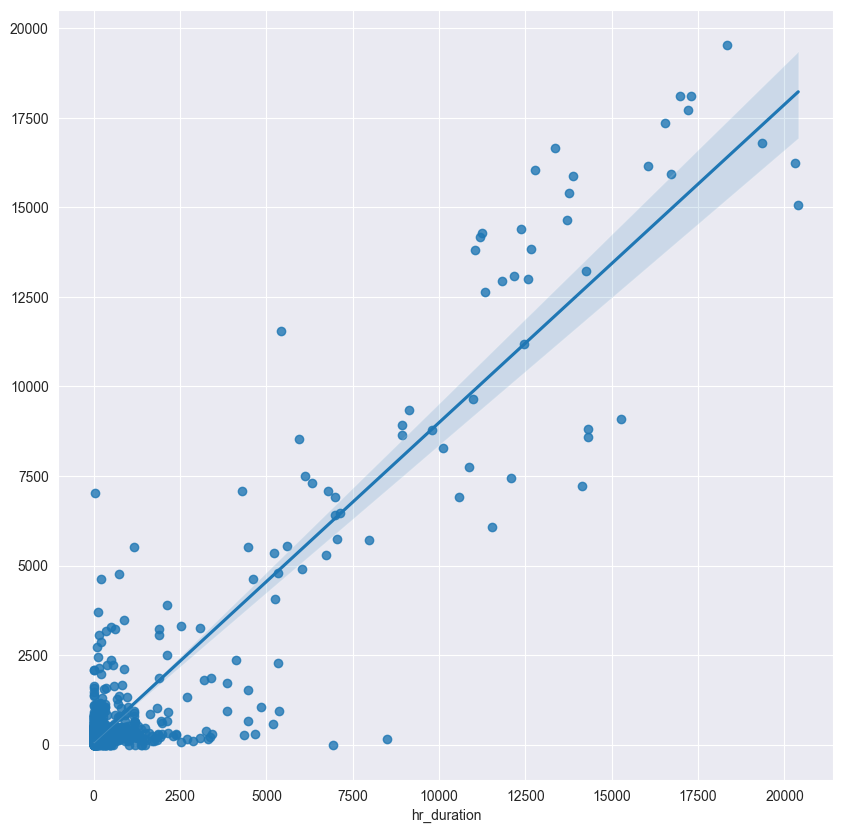

In [23]:
sns.regplot(y=y_pred, x=y_test)

# 4 Explainer

In [24]:
from explainerdashboard.explainers import RegressionExplainer

In [25]:
explainer = RegressionExplainer(model=model,
                                X=X_test,
                                y=y_test)



Generating self.shap_explainer = shap.TreeExplainer(model)


In [27]:
from explainerdashboard import ExplainerDashboard
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...


C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` wi

Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://10.180.74.184:8050


C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` wi

C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\A200083283\OneDrive - Deutsche Telekom AG\non_DT\others\venv\lib\site-packages\explainerdashboard\explainer_methods.py:791: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` wi